In [21]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, ConfusionMatrixDisplay)
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from IPython.display import display

In [22]:
# Load the dataset
url = "CSC14003_Decision_Tree/data/processed.cleveland.data"
columns = [
    "age",
    "sex",
    "cp",
    "trestbps",
    "chol",
    "fbs",
    "restecg",
    "thalach",
    "exang",
    "oldpeak",
    "slope",
    "ca",
    "thal",
    "target",
]

df = pd.read_csv(url, names=columns, na_values="?")

# Drop rows with missing values
df.dropna()
display(df)

# Convert categorical variables to category type
df["target"] = df["target"].apply(lambda x: 1 if x > 0 else 0)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,45.0,1.0,1.0,110.0,264.0,0.0,0.0,132.0,0.0,1.2,2.0,0.0,7.0,1
299,68.0,1.0,4.0,144.0,193.0,1.0,0.0,141.0,0.0,3.4,2.0,2.0,7.0,2
300,57.0,1.0,4.0,130.0,131.0,0.0,0.0,115.0,1.0,1.2,2.0,1.0,7.0,3
301,57.0,0.0,2.0,130.0,236.0,0.0,2.0,174.0,0.0,0.0,2.0,1.0,3.0,1


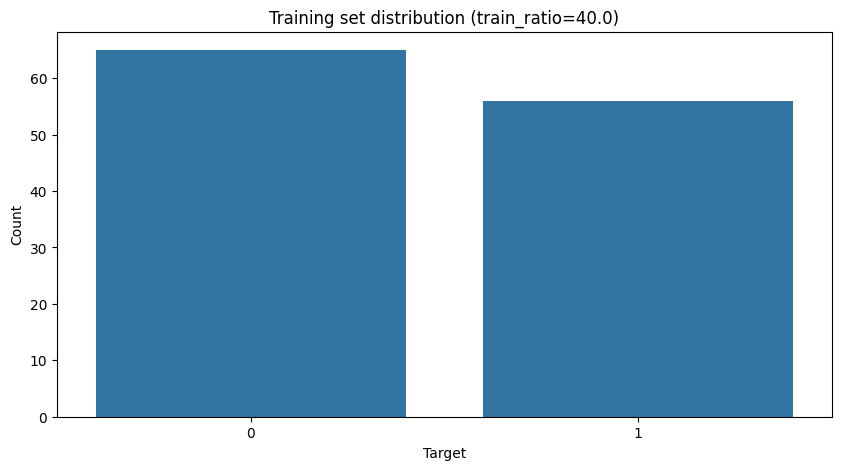

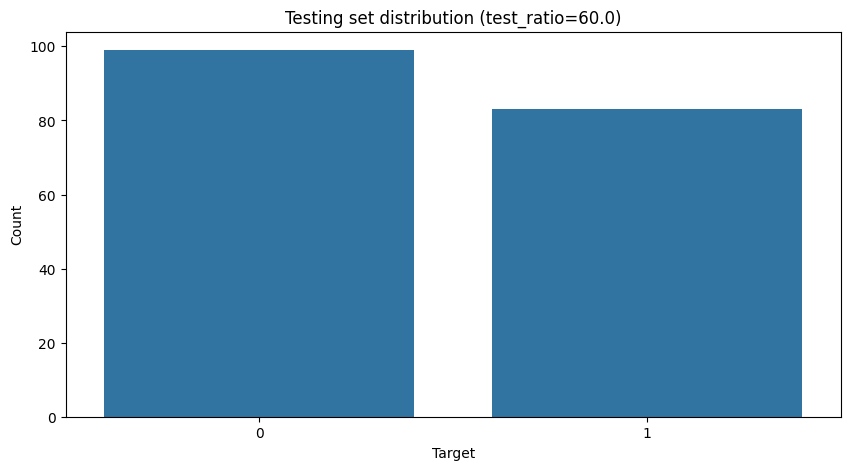

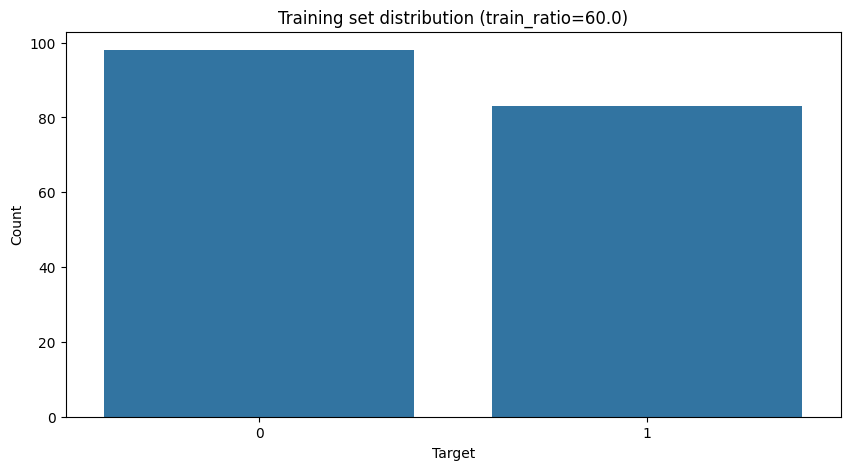

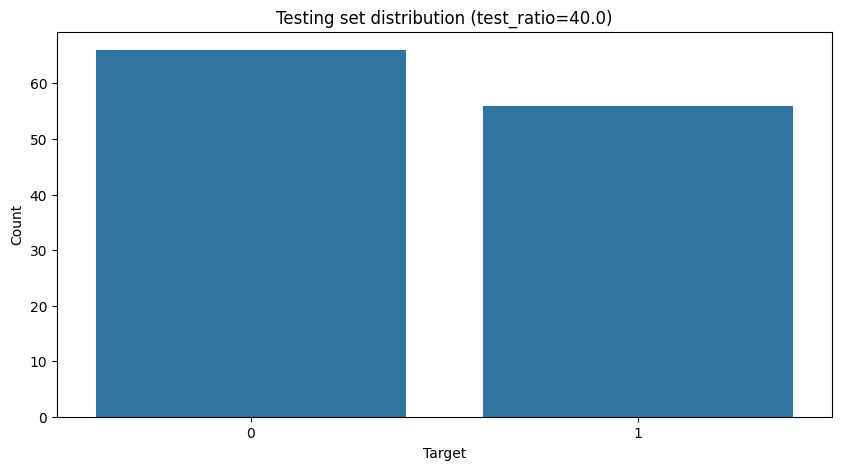

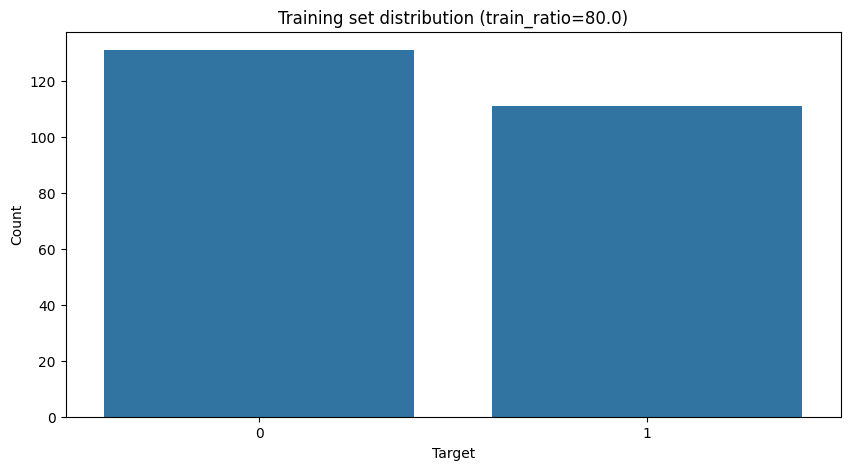

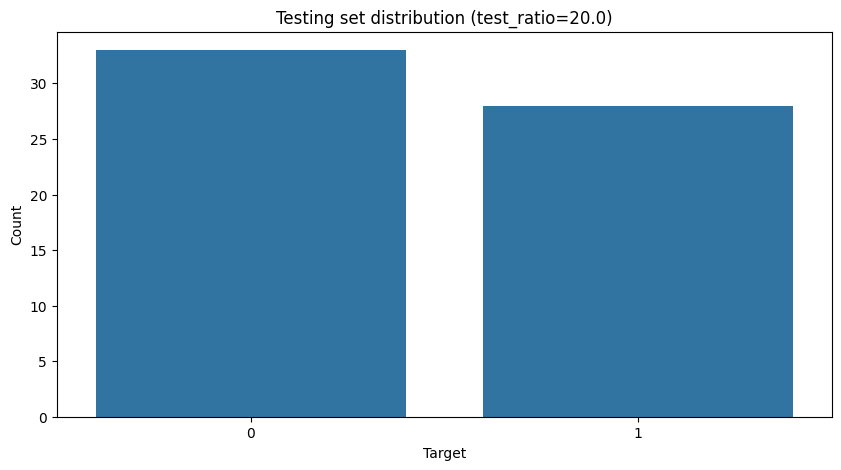

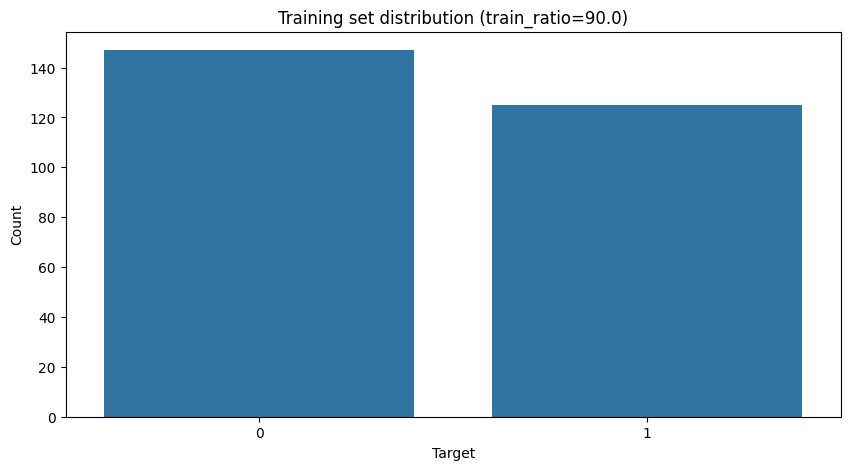

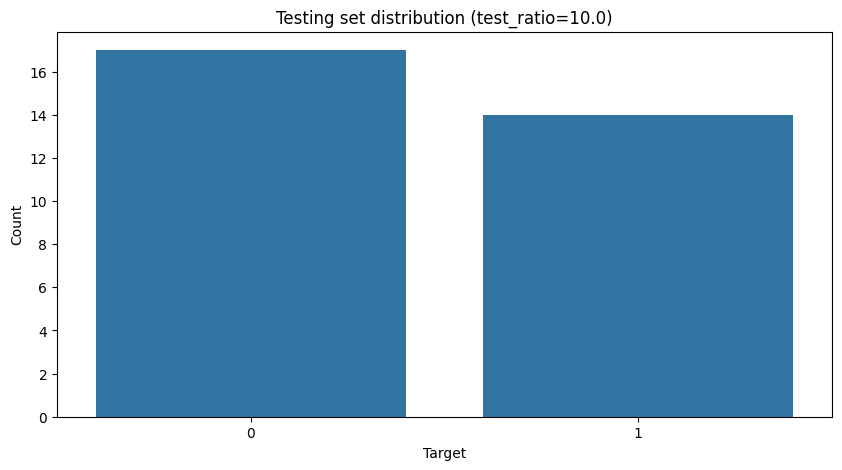

In [23]:
# Feature and label separation
feature = df.drop("target", axis=1)
label = df["target"]

# Train-test split
splits = [0.4, 0.6, 0.8, 0.9]
split_results = {}

for train_ratio in splits:
    feature_train, feature_test, label_train, label_test = train_test_split(
        feature, label, train_size=train_ratio, random_state=42, stratify=label, shuffle=True
    )

    split_results[train_ratio] = {
        "feature_train": feature_train,
        "feature_test": feature_test,
        "label_train": label_train,
        "label_test": label_test,
    }

    # Visualize trainning and testing set distribution
    plt.figure(figsize=(10, 5))
    sns.countplot(x=label_train)
    plt.title(f"Training set distribution (train_ratio={train_ratio * 100})")
    plt.xlabel("Target")
    plt.ylabel("Count")
    plt.show()

    plt.figure(figsize=(10, 5))
    sns.countplot(x=label_test)
    plt.title(f"Testing set distribution (test_ratio={100 - train_ratio * 100})")
    plt.xlabel("Target")
    plt.ylabel("Count")
    plt.show()

Accuracy (train_ratio=0.4): 0.73
              precision    recall  f1-score   support

           0       0.80      0.68      0.73        99
           1       0.67      0.80      0.73        83

    accuracy                           0.73       182
   macro avg       0.74      0.74      0.73       182
weighted avg       0.74      0.73      0.73       182



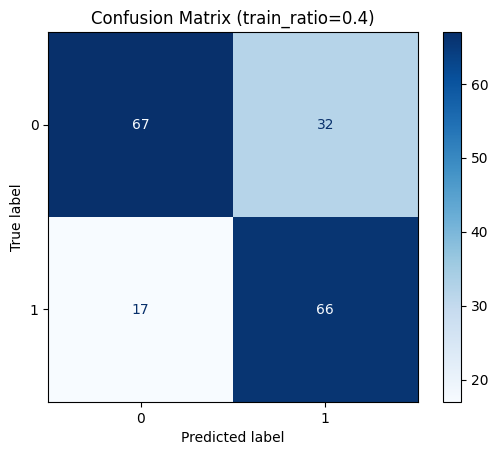

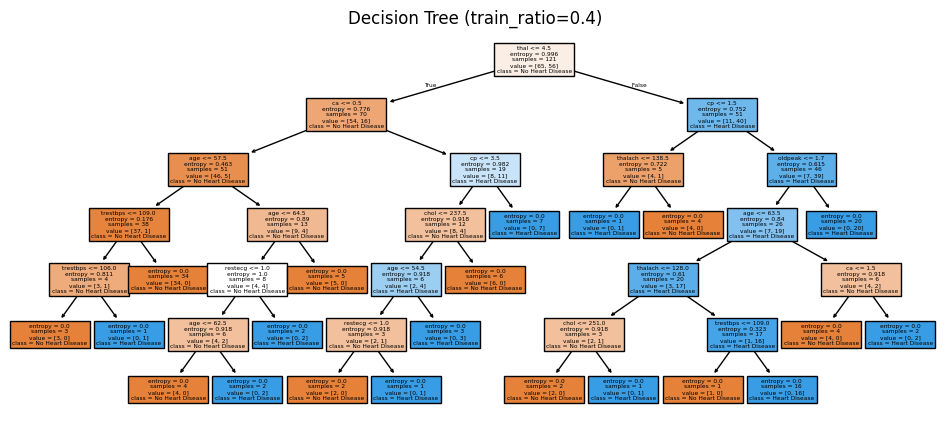

Accuracy (train_ratio=0.6): 0.75
              precision    recall  f1-score   support

           0       0.79      0.74      0.77        66
           1       0.72      0.77      0.74        56

    accuracy                           0.75       122
   macro avg       0.75      0.76      0.75       122
weighted avg       0.76      0.75      0.75       122



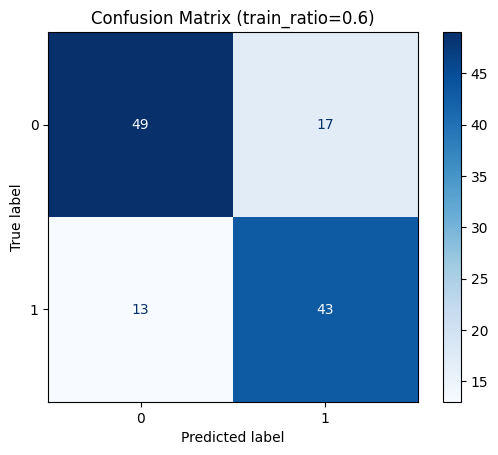

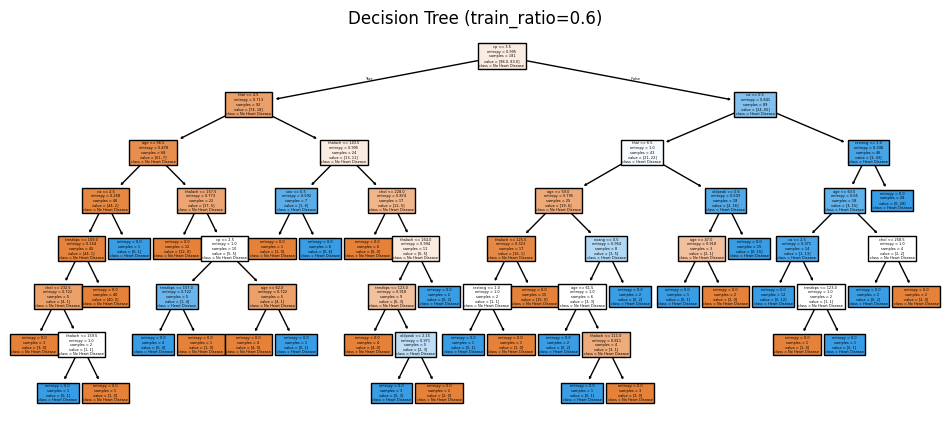

Accuracy (train_ratio=0.8): 0.77
              precision    recall  f1-score   support

           0       0.88      0.67      0.76        33
           1       0.69      0.89      0.78        28

    accuracy                           0.77        61
   macro avg       0.79      0.78      0.77        61
weighted avg       0.79      0.77      0.77        61



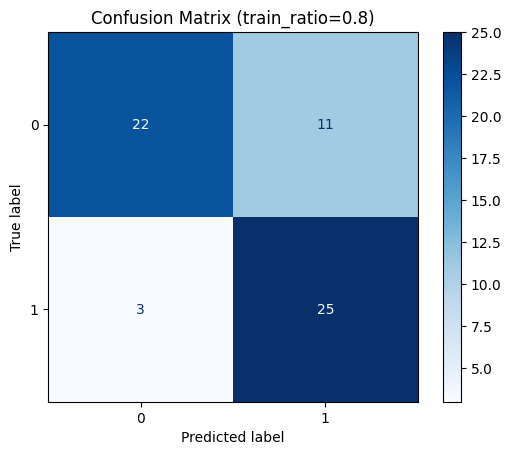

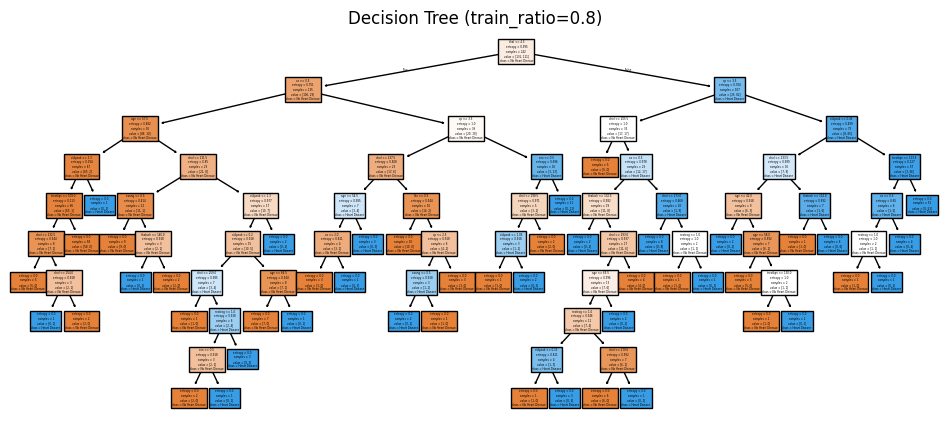

Accuracy (train_ratio=0.9): 0.74
              precision    recall  f1-score   support

           0       0.91      0.59      0.71        17
           1       0.65      0.93      0.76        14

    accuracy                           0.74        31
   macro avg       0.78      0.76      0.74        31
weighted avg       0.79      0.74      0.74        31



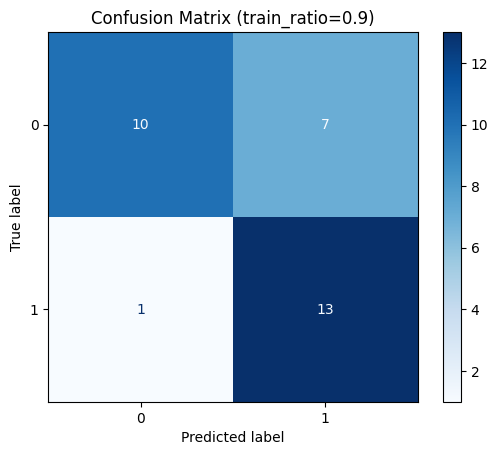

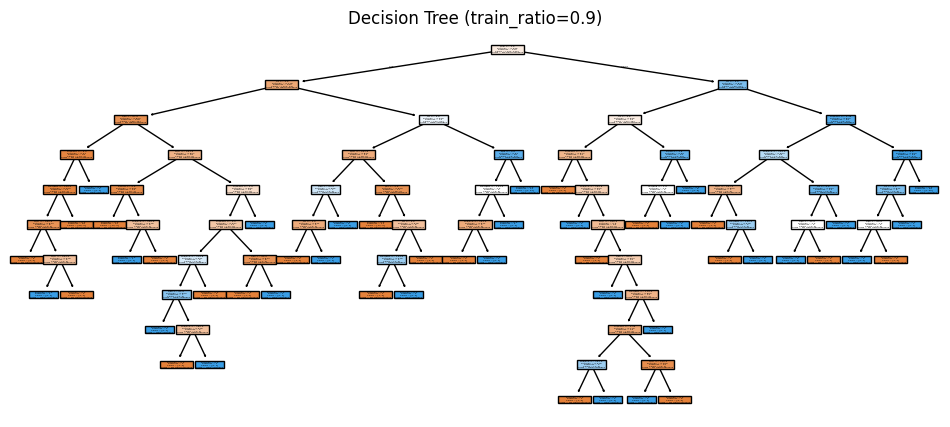

In [24]:
# Decision Tree Classifier
for train_ratio, data in split_results.items():
    feature_train = data["feature_train"]
    label_train = data["label_train"]
    feature_test = data["feature_test"]
    label_test = data["label_test"]

    # Train the model
    clf = DecisionTreeClassifier(criterion="entropy", random_state=42)
    clf.fit(feature_train, label_train)

    # Make predictions
    label_pred = clf.predict(feature_test)

    # Evaluate the model
    accuracy = accuracy_score(label_test, label_pred)
    print(f"Accuracy (train_ratio={train_ratio}): {accuracy:.2f}")

    # Classification report
    report = classification_report(label_test, label_pred)
    print(report)

    # Confusion matrix
    cm = confusion_matrix(label_test, label_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
    disp.plot(cmap= plt.cm.Blues)
    plt.title(f"Confusion Matrix (train_ratio={train_ratio})")
    plt.show()

    # Visualize the decision tree
    plt.figure(figsize=(12, 5))
    plot_tree(clf, filled=True, feature_names=feature.columns, class_names=["No Heart Disease", "Heart Disease"])
    plt.title(f"Decision Tree (train_ratio={train_ratio})")
    plt.show() 

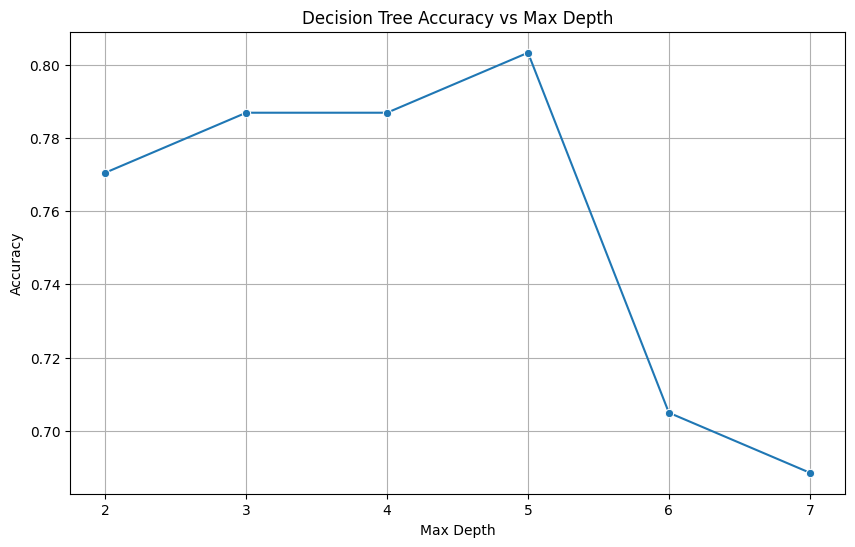

In [25]:
# Analyze accuracy vs max_depth
split_80 = split_results[0.8]
feature_train = split_80["feature_train"]
feature_test = split_80["feature_test"]
label_train = split_80["label_train"]
label_test = split_80["label_test"]

max_depths = [None, 2, 3, 4, 5, 6, 7]
depth_results = []

for max_depth in max_depths:
    model = DecisionTreeClassifier(criterion="entropy", max_depth=max_depth, random_state=42)
    model.fit(feature_train, label_train)

    prediction = model.predict(feature_test)
    accuracy = accuracy_score(label_test, prediction)
    depth_results.append({  
        "max_depth": None if max_depth is None else max_depth,
        "accuracy": accuracy
    })

# Plot accuracy vs max_depth
depth_df = pd.DataFrame(depth_results)
plt.figure(figsize=(10, 6))
sns.lineplot(data=depth_df, x="max_depth", y="accuracy", marker="o")
plt.title("Decision Tree Accuracy vs Max Depth")
plt.xlabel("Max Depth")
plt.ylabel("Accuracy")
plt.grid()
plt.show()